> # **Gradient Boosting Regressor**
>
>The dataframe used in this notebook originates from the preprocessing steps 
>performed in the `"1_4b-preprocessing-feature-engineering-and-preprocessing-for-predictive-models.ipynb"` notebook.
>The final refinement of selected variables is conducted here to meet the 
>specific requirements of the models being developed, based on insights from 
>the aforementioned notebook.

In [ ]:
# Importing Required Libraries

import os

import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from scipy.stats import mstats
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split

c:\Users\leone\Project\local_project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Importing Required Libraries

df = pd.read_csv("gradient_boosting_regressor.csv", index_col = 0, sep = ",")

In [3]:
df.head()

,mass_vehicle,engine_capacity,engine_power,erwltp,year,electric_range,fuel_consumption,specific_co2_emissions,electric_energy_consumption,fuel_type_diesel/electric,...,fuel_type_petrol/electric,has_innovation,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7
ID,,,,,,,,,,,,,,,,,,,,,
56003309,1710.0,2487.0,131.0,0.0,2021,0.0,5.7,128.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56003313,1710.0,2487.0,131.0,0.0,2021,0.0,5.7,128.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56003314,1710.0,2487.0,131.0,0.0,2021,0.0,5.7,128.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56003351,1635.0,1987.0,129.0,0.0,2021,0.0,7.1,160.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56003352,1635.0,1987.0,129.0,0.0,2021,0.0,7.1,160.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Feature–Target Split

target = df["electric_energy_consumption"]
data = df.drop(["electric_energy_consumption"], axis = 1)

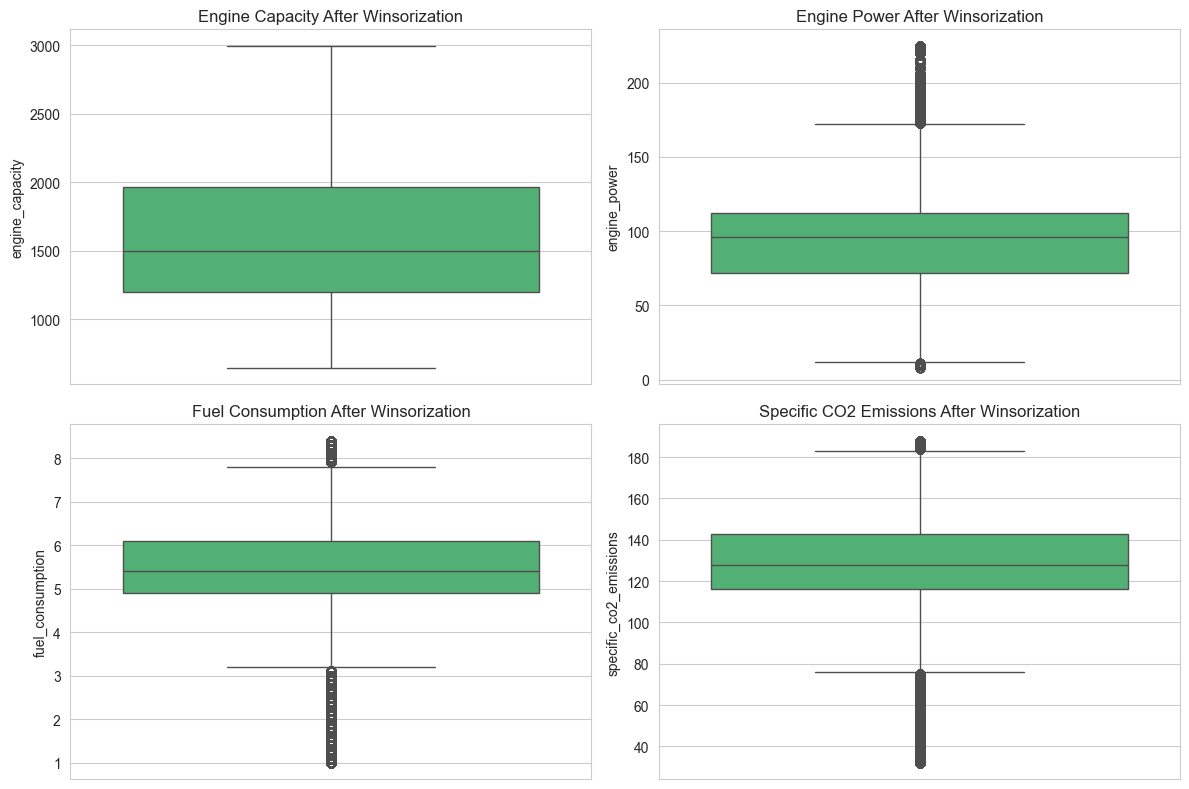

In [ ]:
# Winsorizing Selected Variables to Handle Outliers

data["engine_capacity"] = mstats.winsorize(data["engine_capacity"], limits = [0, 0.01])
data["engine_power"] = mstats.winsorize(data["engine_power"], limits = [0, 0.03])
data["fuel_consumption"] = mstats.winsorize(data["fuel_consumption"], limits = [0.01, 0.03])
data["specific_co2_emissions"] = mstats.winsorize(data["specific_co2_emissions"], limits = [0.05, 0.05])

# Visualize the results
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize = (12, 8))

sns.boxplot(data["engine_capacity"], color = plt.cm.viridis(0.7), ax = axes[0, 0])
axes[0, 0].set_title("Engine Capacity After Winsorization")

sns.boxplot(data["engine_power"], color = plt.cm.viridis(0.7), ax = axes[0, 1])
axes[0, 1].set_title("Engine Power After Winsorization")

sns.boxplot(data["fuel_consumption"], color = plt.cm.viridis(0.7), ax = axes[1, 0])
axes[1, 0].set_title("Fuel Consumption After Winsorization")

sns.boxplot(data["specific_co2_emissions"], color = plt.cm.viridis(0.7), ax = axes[1, 1])
axes[1, 1].set_title("Specific CO2 Emissions After Winsorization")

plt.tight_layout()
plt.show()

# Apply Winsorization to handle outliers in key variables
# The following variables are Winsorized to reduce the impact of extreme values:
# - engine_capacity (1% upper limit)
# - engine_power (3% upper limit)
# - fuel_consumption (3% upper limit)
# - specific_co2_emissions (5% lower and 5% upper limit)

# Note: electric_range and electric_energy_consumption are not Winsorized because their
# high values might reflect real differences in electric vehicle performance rather than
# measurement errors or anomalies.

In [ ]:
# Applying Logarithm to electric_range to Reduce Skewness
data["electric_range"] = np.log1p(data["electric_range"])

> The logarithmic transformation was applied to `electric_range` to reduce skewness and improve data distribution. This step ensures a more normalized feature, which may enhance model performance.


In [ ]:
# Splitting Data into Training and Testing Sets and Converting Dataset to Float32

x_train, x_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, random_state = 42)

x_train = x_train.astype("float32")
y_train = y_train.astype("float32")

In [ ]:
# Save the datasets (train-test split)
joblib.dump((x_train, x_test, y_train, y_test), "train_test_split.pkl")

print("Train-test split saved successfully!")


Train-test split saved successfully!


In [ ]:
# Load datasets (if needed)
x_train, x_test, y_train, y_test = joblib.load("train_test_split.pkl")

print("Train-test split loaded successfully!")


Train-test split loaded successfully!


In [ ]:
# Hyperparameter Optimization with Optuna

# 🔹 File to save study progress
STUDY_DB = "optuna_study.pkl"

# 🔹 Load existing study or create a new one
if os.path.exists(STUDY_DB):
    try:
        study = joblib.load(STUDY_DB)
        print("✅ Loaded existing study!")
    except Exception:
        print("⚠️ Error loading study! Creating a new one...")
        study = optuna.create_study(direction = "maximize")
else:
    study = optuna.create_study(direction = "maximize")
    print("📌 Creating a new study...")

# 🔹 Objective function
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 100),
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.1),
        "max_depth": trial.suggest_int("max_depth", 2, 3),
        "subsample": trial.suggest_float("subsample", 0.8, 1.0),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 5),
    }

    model = GradientBoostingRegressor(**params, random_state = 42)

    # Lower CV folds for faster execution
    score = cross_val_score(model, x_train, y_train, cv = 3, scoring = "r2").mean()

    # Save study every **5 trials**
    if trial.number % 5 == 0:
        joblib.dump(study, STUDY_DB)
        print(f"💾 Progress saved after {trial.number} trials.")

    return score

# 🔹 Run optimization
try:
    study.optimize(objective, n_trials=3)
except KeyboardInterrupt:
    print("\n⏹️ Interrupted by user! Saving progress...")
finally:
    joblib.dump(study, STUDY_DB)
    print(f"📁 Final study saved in '{STUDY_DB}'.")

# 🔹 Display best hyperparameters
print("🎯 Best hyperparameters:", study.best_params)

c:\Users\leone\Project\local_project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-03-20 21:39:51,025] A new study created in memory with name: no-name-590cb59a-e92b-4e41-be8c-6d4f7246e2b9


📌 Creating a new study...


[I 2025-03-20 23:15:59,684] Trial 0 finished with value: 0.9827503396710101 and parameters: {'n_estimators': 78, 'learning_rate': 0.05246298051609523, 'max_depth': 3, 'subsample': 0.9243129942569372, 'min_samples_split': 2}. Best is trial 0 with value: 0.9827503396710101.


💾 Progress saved after 0 trials.


[I 2025-03-21 00:14:07,945] Trial 1 finished with value: 0.9755435051136153 and parameters: {'n_estimators': 68, 'learning_rate': 0.06928544820980602, 'max_depth': 2, 'subsample': 0.9944893529086265, 'min_samples_split': 4}. Best is trial 0 with value: 0.9827503396710101.
[I 2025-03-21 01:28:03,107] Trial 2 finished with value: 0.9861910049945332 and parameters: {'n_estimators': 74, 'learning_rate': 0.09928545039967425, 'max_depth': 3, 'subsample': 0.8345420288744889, 'min_samples_split': 5}. Best is trial 2 with value: 0.9861910049945332.


📁 Final study saved in 'optuna_study.pkl'.
🎯 Best hyperparameters: {'n_estimators': 74, 'learning_rate': 0.09928545039967425, 'max_depth': 3, 'subsample': 0.8345420288744889, 'min_samples_split': 5}


In [ ]:
# Displaying the Best Hyperparameters from the Study

try:
    best_params = study.best_params
    print("✅ Best hyperparameters found:", best_params)
except AttributeError:
    print("❌ No hyperparameters were found in the study.")

✅ Melhores hiperparâmetros encontrados: {'n_estimators': 74, 'learning_rate': 0.09928545039967425, 'max_depth': 3, 'subsample': 0.8345420288744889, 'min_samples_split': 5}


In [ ]:
# Cross-validation

# Load the saved Optuna study
study = joblib.load("optuna_study.pkl")

# Extract the best hyperparameters
best_params = study.best_params

# Create the model with the best hyperparameters
best_model = GradientBoostingRegressor(**best_params, random_state = 42)

# Run cross-validation with cv=3 (or another desired value)
cv_scores = cross_val_score(best_model, x_train, y_train, cv = 3, scoring = "r2")

# Display the results
print("Cross-Validation R² Scores:", cv_scores)
print("Average R² Score:", np.mean(cv_scores))
print("R² Variance:", np.var(cv_scores))

Cross-Validation R² Scores: [0.98616907 0.98608019 0.98632375]
Average R² Score: 0.9861910049945332
R² Variance: 1.0126952127556538e-08


In [ ]:
# Load the saved Optuna study
study = joblib.load("optuna_study.pkl")

# Extract the best hyperparameters
best_params = study.best_params

# Train the final model with best parameters
best_model = GradientBoostingRegressor(**best_params, random_state = 42)
best_model.fit(x_train, y_train)

# Save the trained model
joblib.dump(best_model, "best_gradient_boosting_model.pkl")
print("✅ Final model trained and saved successfully!")


✅ Modelo treinado e salvo com sucesso!


In [ ]:
best_model = joblib.load("best_gradient_boosting_model.pkl")
print("Model loaded successfully!")

In [ ]:
# Predictions
def predict_in_chunks(model, data, chunk_size = 5000):
    predictions = []
    for i in range(0, len(data), chunk_size):
        chunk_pred = model.predict(data[i:i+chunk_size])
        predictions.extend(chunk_pred)
    return np.array(predictions)

y_pred_train = predict_in_chunks(best_model, x_train)
print("Training set predictions completed.")

y_pred_test = predict_in_chunks(best_model, x_test)
print("Test set predictions completed.")


Training set predictions completed.
Test set predictions completed.


In [16]:
# Model evaluation
def evaluate_model(y_true, y_pred, dataset_type = "Test"):
    print(f"{dataset_type} Set Evaluation:")
    print(f"R2 Score: {r2_score(y_true, y_pred): .4f}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_true, y_pred): .4f}")
    print(f"Mean Squared Error: {mean_squared_error(y_true, y_pred): .4f}")
    print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_true, y_pred)): .4f}\n")

evaluate_model(y_train, y_pred_train, "Train")
evaluate_model(y_test, y_pred_test, "Test")

Train Set Evaluation:
R2 Score:  0.9859
Mean Absolute Error:  1.0080
Mean Squared Error:  40.3907
Root Mean Squared Error:  6.3554

Test Set Evaluation:
R2 Score:  0.9858
Mean Absolute Error:  1.0099
Mean Squared Error:  40.5928
Root Mean Squared Error:  6.3712



In [ ]:
# Electric Energy Consumption Mean
nonzero_mean = df.loc[df["electric_energy_consumption"] != 0, "electric_energy_consumption"].mean()
print("Electric Energy Consumption Mean):", nonzero_mean)


Electric Energy Consumption Mean): 182.39659069473447


### Analysis of the Results

**Train Set Evaluation:**  
- **R2 Score:** 0.9859  
- **Mean Absolute Error:** 1.0080  
- **Mean Squared Error:** 40.3907  
- **Root Mean Squared Error:** 6.3554  

**Test Set Evaluation:**  
- **R2 Score:** 0.9858  
- **Mean Absolute Error:** 1.0099  
- **Mean Squared Error:** 40.5928  
- **Root Mean Squared Error:** 6.3712  

**Additional Insight:**  
- **Mean Electric Energy Consumption (excluding zeros):** 182.3966  

The evaluation metrics for both the training and test sets indicate excellent model performance. With R2 scores close to 0.986, the model explains nearly 98.6% of the variability in electric energy consumption. The low MAE, MSE, and RMSE values confirm the high accuracy of the predictions. Moreover, the near-identical performance between the training and test sets suggests that the model generalizes very well, with no significant signs of overfitting. Overall, these results validate the robustness and reliability of the model.

### RMSE Analysis in Context of Electric Energy Consumption Scale

The average electric energy consumption (excluding zeros) is approximately 182.4, with it the the RMSE value can be better contextualized. With a test set RMSE of about 6.37, the model’s predictions deviate on average by roughly 3.5% relative to the mean consumption (6.37 / 182.4 ≈ 0.0349). This indicates that, on average, the prediction error is small relative to the scale of the target variable.


**Overall, although the low RMSE suggests robust model performance, further analysis is warranted to confirm that the error is consistently low across all observations.**

### Comparing RMSE and MAE in the Context of the Target Scale

Given the average electric energy consumption of approximately 182.4, we observe the following:

- **RMSE (≈ 6.37):**  
  This metric indicates that, on average, the squared error leads to a deviation of about 3.5% relative to the scale of the target. RMSE is particularly sensitive to larger errors, which suggests that there may be a few predictions with considerably higher deviations that inflate this value.

- **MAE (≈ 1.01):**  
  The Mean Absolute Error shows an average deviation of about 0.55% relative to the target's scale. This much lower value implies that most predictions are very close to the actual values, and the typical error is minimal.

**Interpretation:**  
The notable discrepancy between RMSE and MAE indicates that while the majority of the predictions are highly accurate (as evidenced by the low MAE), there are some larger errors that disproportionately affect the RMSE.  

**Interpretation of the Difference and its possible meaning:**  
- The fact that RMSE is much larger than MAE indicates that, although most predictions are very accurate (as reflected by the low MAE), there are a few instances where the error is quite high.  
- This discrepancy highlights the presence of outliers or extreme errors in the data, which can have a substantial impact on RMSE but are averaged out in MAE.



C:\Users\leone\AppData\Local\Temp\ipykernel_4796\2293610261.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = importances[sorted_idx],


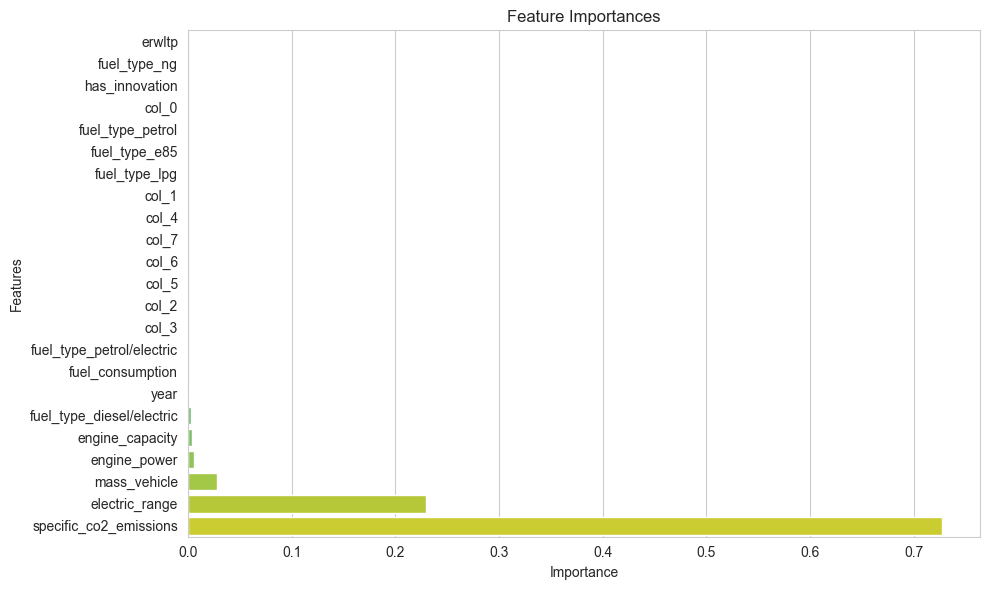

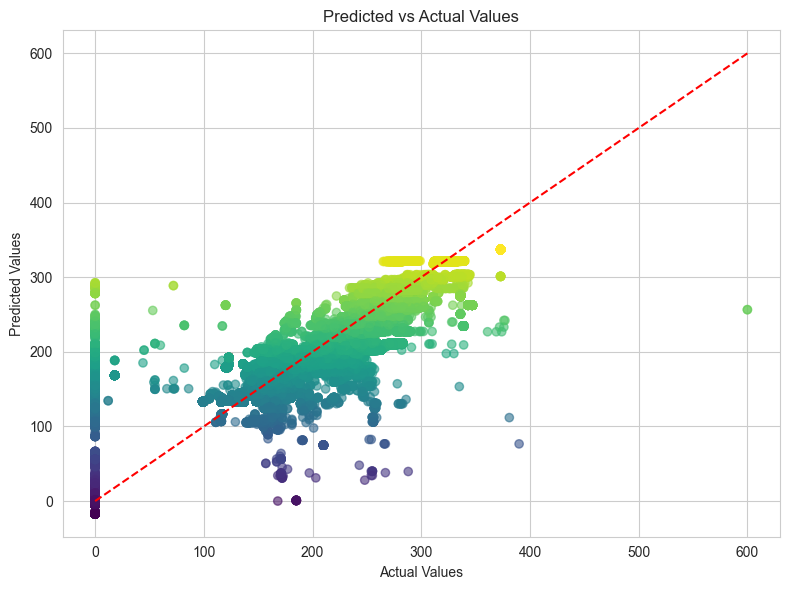

In [ ]:
# Plot feature importance

# Feature importances
feature_names = x_train.columns
importances = best_model.feature_importances_

sorted_idx = np.argsort(importances)

plt.figure(figsize = (10, 6))
sns.barplot(x = importances[sorted_idx],
            y = feature_names[sorted_idx],
            palette = "viridis")
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

# Plot predicted vs. actual values
plt.figure(figsize = (8, 6))
plt.scatter(y_test,y_pred_test,
            c = y_pred_test,
            cmap = "viridis",
            alpha = 0.6)
plt.plot([y_test.min(),
            y_test.max()],
            [y_test.min(),
            y_test.max()],
            "--",
            color = "red")
plt.title("Predicted vs Actual Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.tight_layout()
plt.show()


### Feature Importance Analysis

> The bar chart indicates that **`specific_co2_emissions`**, **`mass_vehicle`**, and **`electric_range`** stand out as the top three predictors for electric energy consumption. This suggests that emission levels, vehicle weight, and battery range are the strongest drivers in the model’s predictions.
>
> Other features such as **`engine_power`** and **`engine_capacity`** show comparatively lower importance, implying that their effect may be overshadowed by the more dominant predictors or potentially correlated with them. Similarly, fuel type indicators4appear to contribute minimally, which could mean their information is either captured by the main features or not as relevant for explaining consumption.
>
> **Key Observations:**
> - **`specific_co2_emissions`** being the most important feature indicates a strong linkage between CO₂ emissions and overall energy usage.  
> - **`mass_vehicle`** aligns with the expectation that heavier vehicles typically require more energy.  
> - **`electric_range`** reveals how battery capacity or efficiency significantly impacts consumption patterns.
>
> **Predicted vs. Actual Values:**  
> The scatter plot comparing predicted and actual values shows a strong alignment along the diagonal, suggesting that the model captures the main consumption drivers effectively. Some dispersion is visible at higher consumption levels, indicating that extreme or less common scenarios may introduce slightly larger errors. Overall, the feature importance chart and the prediction plot together reinforce the model’s ability to generalize well while highlighting the dominant factors influencing electric energy consumption.

### Key Insights on Variables

> **Specific CO2 Emissions:**  
> - Although typically associated with combustion engines, in mixed or hybrid vehicle datasets, this metric can serve as a proxy for overall efficiency.  
> - Lower specific CO2 emissions may indicate a greater reliance on electric propulsion or more efficient energy use, which correlates with electric energy consumption patterns.
>  
> **Mass Vehicle:**  
> - Represents the vehicle’s weight, a primary driver of energy demand.  
> - Heavier vehicles generally require more energy to operate, leading to higher electric energy consumption.
>  
> **Electric Range:**  
> - Reflects battery capacity and overall energy efficiency.  
> - A longer electric range suggests that the vehicle can travel further on a given charge, potentially indicating more efficient energy usage or advanced powertrain technology, often showing an inverse relationship with energy consumption.
